In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score
import math, time

# ----------------- CONFIG (simpler) -----------------
CSV_PATH = '/content/processed_features_scenario1p3n23f.csv'
RANDOM_STATE = 42

MIN_ROWS_FOR_SPLIT = 3

# If True use per-user 0.99 percentile threshold; else global percentile
PER_USER_THRESHOLD = True
PCT_THRESHOLD = 99

# features to treat as already-normalized / flags (do NOT per-user normalize these)
NO_NORMALIZE_COLUMNS = [
    # flags / categorical / label
    "is_weekend","wikileaks_flag","offhour_logon_flag","offhour_usb_flag","offhour_http_flag",
    "is_first_time_usb_user","rare_usb_user","scenario","is_malicious",'user','day',
    # z-scores (already normalized)
    "usb_connect_disconnect_zscore","http_offhour_requests_zscore",
    "session_duration_hours_zscore","total_http_requests_zscore",
    # rolling percentiles & stds (already relative)
    "logon_online_duration_rollpct_7d","logon_online_duration_rollpct_30d",
    "logon_offhour_count_rollpct_7d","logon_offhour_count_rollpct_30d",
    "logon_distinct_pcs_rollpct_7d","logon_distinct_pcs_rollpct_30d",
    "http_total_requests_rollpct_7d","http_total_requests_rollpct_30d",
    "http_unique_domains_rollpct_7d","http_unique_domains_rollpct_30d",
    "device_usb_count_rollpct_7d","device_usb_count_rollpct_30d",
    "device_total_usb_duration_rollpct_7d","device_total_usb_duration_rollpct_30d",
    "device_afterhours_usb_rollpct_7d","device_afterhours_usb_rollpct_30d",
    "logon_online_duration_rollstd_7d","logon_online_duration_rollstd_30d",
    "http_total_requests_rollstd_7d","http_total_requests_rollstd_30d",
    "device_usb_count_rollstd_7d","device_usb_count_rollstd_30d",
]

RULE_FLAG_NAMES = ["is_weekend","wikileaks_flag","offhour_logon_flag","offhour_usb_flag","offhour_http_flag"]
RULE_WEIGHTS = {"wikileaks_flag":1.0, "offhour_usb_flag":0.7, "offhour_http_flag":0.3, "offhour_logon_flag":0.3}

# ----------------- LOAD -----------------
df = pd.read_csv(CSV_PATH)
assert 'user' in df.columns and 'day' in df.columns and 'is_malicious' in df.columns
df['day'] = pd.to_datetime(df['day'])

In [8]:
# ----------------- SPLIT per-user time-respecting (train/val/test) -----------------
def per_user_time_split_train_test(df, train_frac=0.5, min_rows=3):
    """
    Per-user time-respecting split into train/test.
    Users with fewer than min_rows go entirely into train (so we have baseline stats).
    Ensures at least 1 row in train and 1 row in test when possible.
    """
    train_parts, test_parts = [], []
    for user, g in df.groupby('user'):
        g = g.sort_values('day')
        n = len(g)
        if n < min_rows:
            train_parts.append(g)
            continue
        # allocate at least one row to each side when possible
        i1 = int(math.floor(train_frac * n))
        if i1 < 1:
            i1 = 1
        if i1 >= n:
            i1 = n - 1
        train_parts.append(g.iloc[:i1])
        test_parts.append(g.iloc[i1:])
    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df  = pd.concat(test_parts).reset_index(drop=True) if test_parts else pd.DataFrame(columns=df.columns)
    return train_df, test_df


# Replace the 3-way split call:
train_df, test_df = per_user_time_split_train_test(df, train_frac=0.5, min_rows=MIN_ROWS_FOR_SPLIT)

#train_df, val_df, test_df = per_user_time_split(df)
print(f"Split sizes: train={len(train_df)}, test={len(test_df)}")
print("Unique users: train/test:", train_df['user'].nunique(), test_df['user'].nunique())

Split sizes: train=160738, test=160861
Unique users: train/test: 960 960


In [9]:
# ----------------- Determine features: raw-like vs derived -----------------
EXPLICIT_DROP = ['user','day','is_malicious','scenario']
all_features = [c for c in df.columns if c not in EXPLICIT_DROP]
RAW_LIKE = [c for c in all_features if c not in NO_NORMALIZE_COLUMNS]
DERIVED_KEEP = [c for c in all_features if c in NO_NORMALIZE_COLUMNS and c not in ('is_malicious','scenario','user','day',"is_weekend","wikileaks_flag","offhour_logon_flag","offhour_usb_flag","offhour_http_flag")]
print(f"Raw-like features (to normalize): {len(RAW_LIKE)}")
print(f"Derived/flags kept as-is: {len(DERIVED_KEEP)}")

print(DERIVED_KEEP)
print(RAW_LIKE)

# ----------------- Train-benign subset for baseline stats and IF training -----------------
train_ben_df = train_df[train_df['is_malicious']==0].reset_index(drop=True)
if train_ben_df.empty:
    raise ValueError("No benign rows in training partition — cannot fit IF")

# simple impute medians for missing raw-like values before computing stats
medians = train_ben_df[RAW_LIKE].median()

Raw-like features (to normalize): 22
Derived/flags kept as-is: 28
['is_first_time_usb_user', 'rare_usb_user', 'usb_connect_disconnect_zscore', 'http_offhour_requests_zscore', 'session_duration_hours_zscore', 'total_http_requests_zscore', 'logon_online_duration_rollpct_7d', 'logon_online_duration_rollstd_7d', 'logon_online_duration_rollpct_30d', 'logon_online_duration_rollstd_30d', 'logon_offhour_count_rollpct_7d', 'logon_offhour_count_rollpct_30d', 'logon_distinct_pcs_rollpct_7d', 'logon_distinct_pcs_rollpct_30d', 'http_total_requests_rollpct_7d', 'http_total_requests_rollstd_7d', 'http_total_requests_rollpct_30d', 'http_total_requests_rollstd_30d', 'http_unique_domains_rollpct_7d', 'http_unique_domains_rollpct_30d', 'device_usb_count_rollpct_7d', 'device_usb_count_rollstd_7d', 'device_usb_count_rollpct_30d', 'device_usb_count_rollstd_30d', 'device_total_usb_duration_rollpct_7d', 'device_total_usb_duration_rollpct_30d', 'device_afterhours_usb_rollpct_7d', 'device_afterhours_usb_rollpct

In [10]:
# ----------------- Simple per-user med/std (no shrink) -----------------
user_med = train_ben_df.groupby('user')[RAW_LIKE].median()
user_std = train_ben_df.groupby('user')[RAW_LIKE].std().replace(0, 1.0)
global_med = train_ben_df[RAW_LIKE].median()
global_std = train_ben_df[RAW_LIKE].std().replace(0, 1.0)

def norm_df(input_df, features=RAW_LIKE):
    out = pd.DataFrame(index=input_df.index, columns=features, dtype=float)
    for feat in features:
        med_map = user_med[feat]
        std_map = user_std[feat]
        user_means = input_df['user'].map(med_map).fillna(global_med[feat])
        user_stds  = input_df['user'].map(std_map).fillna(global_std[feat])
        vals = input_df[feat].fillna(medians[feat])
        out[feat] = (vals - user_means) / user_stds
    return out.fillna(0.0)

X_train_scaled = norm_df(train_ben_df)
X_test_scaled  = norm_df(test_df)


In [11]:
def assemble_features(df_rows, raw_scaled_df):
    derived = df_rows[DERIVED_KEEP].reset_index(drop=True)
    assembled = pd.concat([raw_scaled_df.reset_index(drop=True), derived.reset_index(drop=True)], axis=1)
    assembled = assembled.apply(pd.to_numeric, errors='coerce').fillna(0.0)
    return assembled

X_train_if = assemble_features(train_ben_df, X_train_scaled)   # fit IF on benign
X_test = assemble_features(test_df, X_test_scaled)

print("X_train_if shape:", X_train_if.shape, "X_test shape:", X_test.shape)

X_train_if shape: (160738, 50) X_test shape: (160861, 50)


In [12]:
# LocalOutlierFactor (novelty mode)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import time

# instantiate - tune n_neighbors as needed; novelty=True allows scoring new data
t0 = time.perf_counter()
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)

# fit on benign training features (X_train_if)
lof.fit(X_train_if)
t1 = time.perf_counter()
print(f"LOF Fit time: {t1 - t0:.4f} seconds")

# Scores: use -decision_function so that higher => more anomalous (consistent with IF block)
train_scores = -lof.decision_function(X_train_if)
test_scores  = -lof.decision_function(X_test)

# attach scores (use method-specific column names so we don't overwrite IF's scores)
tmp_train = train_ben_df.reset_index(drop=True).copy()
tmp_train['anomaly_score_lof'] = train_scores
test_df = test_df.reset_index(drop=True)
test_df['anomaly_score_lof'] = test_scores

# thresholds: same logic as your IF block
global_threshold = np.percentile(train_scores, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train.groupby('user')['anomaly_score_lof'].quantile(pupct)
    test_df['anomaly_threshold_lof'] = test_df['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df['anomaly_threshold_lof'] = global_threshold

# mark anomalies and evaluate
test_df['is_model_anomaly_lof'] = (test_df['anomaly_score_lof'] >= test_df['anomaly_threshold_lof']).astype(int)

# metrics (same as your block)
y_true = test_df['is_malicious'].astype(int).values
y_pred = test_df['is_model_anomaly_lof'].astype(int).values

if len(y_true) == 0:
    print("No rows in test set to evaluate (LOF).")
else:
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)

    print("=== LOF (novelty=True) detection metrics ===")
    print(f"Count (test rows) : {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))


LOF Fit time: 238.6225 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


=== LOF (novelty=True) detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9583
Precision: 0.0124
Recall   : 0.9882
F1 score : 0.0244

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[154068   6708]
 [     1     84]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    160776
           1       0.01      0.99      0.02        85

    accuracy                           0.96    160861
   macro avg       0.51      0.97      0.50    160861
weighted avg       1.00      0.96      0.98    160861



In [13]:
# EllipticEnvelope (robust covariance -> gaussian-ish assumption)
from sklearn.covariance import EllipticEnvelope
import time

t0 = time.perf_counter()
# instantiate: adjust `contamination` to match expected outlier fraction (default ~0.1).
# Use random_state for reproducibility
ee = EllipticEnvelope(contamination=0.1, random_state=RANDOM_STATE)
t1 = time.perf_counter()
print(f"EE Fit time: {t1 - t0:.4f} seconds")

# fit on benign training features
ee.fit(X_train_if)

# decision_function: larger = more normal, so negate to make higher = more anomalous
train_scores = -ee.decision_function(X_train_if)
test_scores  = -ee.decision_function(X_test)

# attach method-specific columns
tmp_train = train_ben_df.reset_index(drop=True).copy()
tmp_train['anomaly_score_elliptic'] = train_scores
test_df = test_df.reset_index(drop=True)
test_df['anomaly_score_elliptic'] = test_scores

# thresholds
global_threshold = np.percentile(train_scores, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train.groupby('user')['anomaly_score_elliptic'].quantile(pupct)
    test_df['anomaly_threshold_elliptic'] = test_df['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df['anomaly_threshold_elliptic'] = global_threshold

# mark anomalies and evaluate
test_df['is_model_anomaly_elliptic'] = (test_df['anomaly_score_elliptic'] >= test_df['anomaly_threshold_elliptic']).astype(int)

# metrics
y_true = test_df['is_malicious'].astype(int).values
y_pred = test_df['is_model_anomaly_elliptic'].astype(int).values

if len(y_true) == 0:
    print("No rows in test set to evaluate (EllipticEnvelope).")
else:
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)

    print("=== EllipticEnvelope detection metrics ===")
    print(f"Count (test rows) : {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))


EE Fit time: 0.0001 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


=== EllipticEnvelope detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9731
Precision: 0.0170
Recall   : 0.8824
F1 score : 0.0335

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[156452   4324]
 [    10     75]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    160776
           1       0.02      0.88      0.03        85

    accuracy                           0.97    160861
   macro avg       0.51      0.93      0.51    160861
weighted avg       1.00      0.97      0.99    160861



In [14]:
# One-Class SVM
from sklearn.svm import OneClassSVM
import time

t0 = time.perf_counter()
# instantiate - tune `nu` roughly near expected contamination (e.g., 0.01..0.1)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)  # adjust nu to match expected outlier rate

# fit on benign training features
ocsvm.fit(X_train_if)
t1 = time.perf_counter()
print(f"ocsvm Fit time: {t1 - t0:.4f} seconds")

# decision_function: larger = more normal, so negate to make higher = more anomalous
train_scores = -ocsvm.decision_function(X_train_if)
test_scores  = -ocsvm.decision_function(X_test)

# attach method-specific columns
tmp_train = train_ben_df.reset_index(drop=True).copy()
tmp_train['anomaly_score_ocsvm'] = train_scores
test_df = test_df.reset_index(drop=True)
test_df['anomaly_score_ocsvm'] = test_scores

# thresholds
global_threshold = np.percentile(train_scores, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = tmp_train.groupby('user')['anomaly_score_ocsvm'].quantile(pupct)
    test_df['anomaly_threshold_ocsvm'] = test_df['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df['anomaly_threshold_ocsvm'] = global_threshold

# mark anomalies and evaluate
test_df['is_model_anomaly_ocsvm'] = (test_df['anomaly_score_ocsvm'] >= test_df['anomaly_threshold_ocsvm']).astype(int)

# metrics
y_true = test_df['is_malicious'].astype(int).values
y_pred = test_df['is_model_anomaly_ocsvm'].astype(int).values

if len(y_true) == 0:
    print("No rows in test set to evaluate (OneClassSVM).")
else:
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)

    print("=== OneClassSVM detection metrics ===")
    print(f"Count (test rows) : {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")
    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))


ocsvm Fit time: 675.8607 seconds
=== OneClassSVM detection metrics ===
Count (test rows) : 160861
Accuracy : 0.9696
Precision: 0.0163
Recall   : 0.9529
F1 score : 0.0321

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[155894   4882]
 [     4     81]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    160776
           1       0.02      0.95      0.03        85

    accuracy                           0.97    160861
   macro avg       0.51      0.96      0.51    160861
weighted avg       1.00      0.97      0.98    160861



In [15]:
# ----------------- Fit IsolationForest on benign training rows -----------------
import time

t0 = time.perf_counter()
clf = IsolationForest(n_estimators=200, max_samples= 'auto', contamination='auto', random_state=RANDOM_STATE)
clf.fit(X_train_if)
t1 = time.perf_counter()
print(f"IF Fit time: {t1 - t0:.4f} seconds")

train_scores = -clf.decision_function(X_train_if)  # higher = more anomalous
test_scores = -clf.decision_function(X_test)

# Attach scores
train_ben_df = train_ben_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_ben_df['anomaly_score'] = train_scores
test_df['anomaly_score'] = test_scores

IF Fit time: 0.7765 seconds


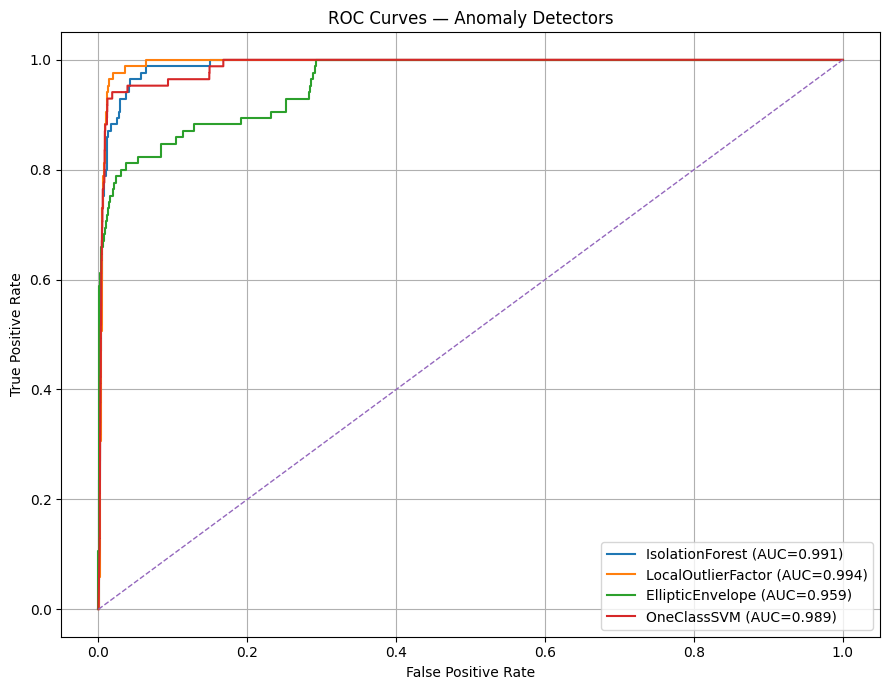

AUC summary:
  IsolationForest     : 0.9908
  LocalOutlierFactor  : 0.9942
  EllipticEnvelope    : 0.9592
  OneClassSVM         : 0.9891


In [16]:
# ROC plot for all anomaly models (single plot, AUC in legend)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# label column (as used in your code)
y_col = 'is_malicious'
if y_col not in test_df.columns:
    raise ValueError(f"Expected `{y_col}` column in test_df but not found.")

# binary true labels
y = test_df[y_col].astype(int).values

# need both classes to compute ROC/AUC
if len(np.unique(y)) < 2:
    print("Cannot compute ROC/AUC: test set does not contain both classes. Found classes:", np.unique(y))
else:
    # map of friendly model names -> column name in test_df containing continuous scores
    model_cols = {
        'IsolationForest'  : 'anomaly_score',          # from your IF block
        'LocalOutlierFactor': 'anomaly_score_lof',     # LOF
        'EllipticEnvelope' : 'anomaly_score_elliptic', # EllipticEnvelope
        'OneClassSVM'      : 'anomaly_score_ocsvm',    # OneClassSVM
    }

    plt.figure(figsize=(9, 7))
    plotted = []

    for name, col in model_cols.items():
        if col not in test_df.columns:
            # skip models you didn't run / didn't produce a score column
            continue

        scores = test_df[col].values
        # align and drop any NaNs (keep labels in sync)
        mask = (~np.isnan(scores)) & (~np.isnan(y))
        if mask.sum() == 0:
            print(f"Skipping {name}: no valid score values.")
            continue

        try:
            auc = roc_auc_score(y[mask], scores[mask])
            fpr, tpr, _ = roc_curve(y[mask], scores[mask])
        except ValueError as e:
            # e.g., only one class present after masking or other issue
            print(f"Skipping {name}: {e}")
            continue

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plotted.append((name, auc))

    # baseline
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves — Anomaly Detectors')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if plotted:
        print("AUC summary:")
        for n, a in plotted:
            print(f"  {n:20s}: {a:.4f}")
    else:
        print("No model score columns found in test_df. Make sure you ran the model cells so columns like 'anomaly_score_lof' exist.")


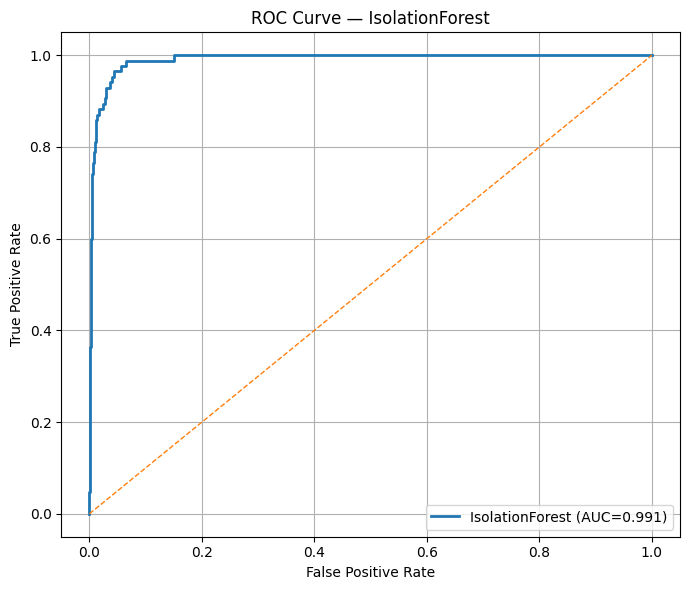

IsolationForest AUC: 0.9908


In [17]:
# ROC for IsolationForest only
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_col = 'is_malicious'
score_col = 'anomaly_score'  # IsolationForest score column in your notebook

if y_col not in test_df.columns:
    raise ValueError(f"Expected `{y_col}` column in test_df but not found.")
if score_col not in test_df.columns:
    raise ValueError(f"Expected `{score_col}` column in test_df but not found. Run the IF block that sets test_df['{score_col}'].")

y = test_df[y_col].astype(int).values
scores = test_df[score_col].values

# mask NaNs (if any)
mask = (~np.isnan(scores)) & (~np.isnan(y))
if mask.sum() == 0:
    raise ValueError("No valid score/label pairs available after removing NaNs.")

unique_classes = np.unique(y[mask])
if len(unique_classes) < 2:
    print("Cannot compute ROC/AUC: test set does not contain both classes. Found classes:", unique_classes)
else:
    auc = roc_auc_score(y[mask], scores[mask])
    fpr, tpr, _ = roc_curve(y[mask], scores[mask])

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'IsolationForest (AUC={auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve — IsolationForest')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # optionally save: plt.savefig('roc_isolation_forest.png', dpi=150)
    plt.show()

    print(f"IsolationForest AUC: {auc:.4f}")


In [18]:
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
y_true = test_df['is_malicious'].astype(int).values
scores = test_df['anomaly_score'].values
print("Average Precision (AP):", average_precision_score(y_true, scores))
print("ROC AUC:", roc_auc_score(y_true, scores))
# optionally plot PR curve (matplotlib)


Average Precision (AP): 0.06962623462023008
ROC AUC: 0.9908476974906996


In [19]:
# ----------------- thresholds: global and per-user -----------------
global_threshold = np.percentile(train_scores, PCT_THRESHOLD)
if PER_USER_THRESHOLD:
    pupct = PCT_THRESHOLD/100.0
    per_user_thresh = train_ben_df.groupby('user')['anomaly_score'].quantile(pupct)
    # fallback for users not present in train benign -> use global
    test_df['anomaly_threshold'] = test_df['user'].map(per_user_thresh).fillna(global_threshold)
else:
    test_df['anomaly_threshold'] = global_threshold

# mark model-detected anomalies (anomaly-only detection)
test_df['is_model_anomaly'] = (test_df['anomaly_score'] >= test_df['anomaly_threshold']).astype(int)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ensure labels/preds exist
if 'is_model_anomaly' not in test_df.columns:
    raise RuntimeError("Column 'is_model_anomaly' not found in test_df")

y_true = test_df['is_malicious'].astype(int).values
y_pred = test_df['is_model_anomaly'].astype(int).values

if len(y_true) == 0:
    print("No rows in test set to evaluate.")
else:
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)  # rows: true, cols: pred

    print("Percentile: ", PCT_THRESHOLD)
    print("=== Detection metrics (anomaly-only thresholding) ===")
    print(f"Count (test rows) : {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}\n")

    print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))


Percentile:  99
=== Detection metrics (anomaly-only thresholding) ===
Count (test rows) : 160861
Accuracy : 0.9864
Precision: 0.0363
Recall   : 0.9647
F1 score : 0.0699

Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[158598   2178]
 [     3     82]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    160776
           1       0.04      0.96      0.07        85

    accuracy                           0.99    160861
   macro avg       0.52      0.98      0.53    160861
weighted avg       1.00      0.99      0.99    160861



In [21]:
# ----------------- Investigation budgets for model-score re-rank -----------------
import numpy as np

# sanity checks
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Run previous blocks first.")
if 'is_model_anomaly' not in test_df.columns:
    raise RuntimeError("'is_model_anomaly' missing in test_df. Run detection thresholding first.")
if 'anomaly_score' not in test_df.columns:
    raise RuntimeError("'anomaly_score' missing in test_df. Run IF scoring first.")

# prepare ranked list of model-detected anomalies by model score (descending)
model_anoms = test_df[test_df['is_model_anomaly'] == 1].copy()
model_anoms = model_anoms.sort_values('anomaly_score', ascending=False).reset_index(drop=True)

# prepare matching keys for mapping back to full test (robust matching)
test_keys = list(zip(test_df['user'], pd.to_datetime(test_df['day'])))
model_keys = list(zip(model_anoms['user'], pd.to_datetime(model_anoms['day'])))

total_tp = int(test_df['is_malicious'].sum())
total_model_alerts = len(model_anoms)

print(f"\nTotal true positives in test set: {total_tp}")
print(f"Total model-detected anomalies: {total_model_alerts}\n")

if total_model_alerts == 0:
    print("No model-detected anomalies to evaluate.")
else:

    # Relative budgets (Top X% of the model-detected alerts)
    percent_budgets = [0.01, 0.02, 0.05, 0.10, 0.15]  # 0.5%,1%,2%,5%,10%
    print("\nModel-score re-rank (Top X%):")
    print(f"{'Top-%':>8} | {'Top-N':>6} | {'% TP in budget':>15} | {'% of all TP covered':>21} | {'TP_in_budget':>12}")
    print("-"*88)
    for p in percent_budgets:
        k = max(1, int(np.floor(p * total_model_alerts)))
        head_keys = set(model_keys[:k])
        in_topk = np.array([1 if key in head_keys else 0 for key in test_keys], dtype=int)
        n_alerts = int(in_topk.sum())
        tp_in_budget = int(((test_df['is_malicious'].astype(int).values) * in_topk).sum())
        precision_pct = (tp_in_budget / n_alerts * 100.0) if n_alerts > 0 else 0.0
        coverage_pct = (tp_in_budget / total_tp * 100.0) if total_tp > 0 else float('nan')
        print(f"{p*100:7.2f}% | {k:6d} | {precision_pct:15.2f} | {coverage_pct:21.2f} | {tp_in_budget:12d}")

print("\nNote: '% TP in budget' = precision within that budget;")
print("      '% of all TP covered' = fraction of total test-set positives found inside the budget.\n")



Total true positives in test set: 85
Total model-detected anomalies: 2260


Model-score re-rank (Top X%):
   Top-% |  Top-N |  % TP in budget |   % of all TP covered | TP_in_budget
----------------------------------------------------------------------------------------
   1.00% |     22 |            9.09 |                  2.35 |            2
   2.00% |     45 |           11.11 |                  5.88 |            5
   5.00% |    113 |           16.81 |                 22.35 |           19
  10.00% |    226 |           17.70 |                 47.06 |           40
  15.00% |    339 |           15.34 |                 61.18 |           52

Note: '% TP in budget' = precision within that budget;
      '% of all TP covered' = fraction of total test-set positives found inside the budget.



In [22]:
 #----------------- Rule scoring function (deterministic) -----------------
def compute_rule_score_row(row):
    score = 0.0
    if row.get("wikileaks_flag",0) == 1:
        score += RULE_WEIGHTS["wikileaks_flag"]
    trio = {"offhour_usb_flag": row.get("offhour_usb_flag",0),
            "offhour_http_flag": row.get("offhour_http_flag",0),
            "offhour_logon_flag": row.get("offhour_logon_flag",0)}
    if trio["offhour_usb_flag"] == 1 and sum(trio.values()) >= 2:
        score += sum(RULE_WEIGHTS[k] for k,v in trio.items() if v==1)
    return score

# precompute rule_score on train/val/test (for tuning if needed)
train_ben_df['rule_score'] = train_ben_df.apply(compute_rule_score_row, axis=1)
test_df['rule_score'] = test_df.apply(compute_rule_score_row, axis=1)


In [23]:
rmean = train_ben_df['rule_score'].mean()
rstd = train_ben_df['rule_score'].std() if train_ben_df['rule_score'].std() > 0 else 1.0
test_df['rule_z'] = (test_df['rule_score'] - rmean) / rstd
rule_z_std = test_df['rule_z'].replace([np.inf,-np.inf], np.nan).dropna().std()
anomaly_std = train_ben_df['anomaly_score'].std()
scale = anomaly_std / (rule_z_std if rule_z_std>0 else 1.0)
test_df['rule_z_scaled'] = test_df['rule_z'] * scale

# ----------------- Re-rank only the model-detected anomalies using hybrid score -----------------
# Note: we DO NOT use hybrid for detection; detection is anomaly-only thresholding above.
anomalies_all = test_df[test_df['is_model_anomaly'] == 1].copy()
HYBRID_ALPHA = 0.5   # use user-selected slider value
anomalies_all['hybrid_score'] = anomalies_all['anomaly_score'] + HYBRID_ALPHA * anomalies_all['rule_z_scaled']

# final re-ranked alerts (descending hybrid_score)
anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

In [24]:
import numpy as np

# anomalies_all must be the re-ranked DataFrame (descending hybrid_score)
# test_df must contain 'is_malicious' for total TPs

# safety checks
if 'anomalies_all' not in globals():
    raise RuntimeError("anomalies_all not found. Run the re-ranking block first.")
if 'test_df' not in globals():
    raise RuntimeError("test_df not found.")

total_tp = int(test_df['is_malicious'].sum())
total_alerts = len(anomalies_all)

print(f"Total re-ranked model-detected anomalies: {total_alerts}")
print(f"Total true positives in test set: {total_tp}\n")

if total_alerts == 0:
    print("No model-detected anomalies to evaluate.")
else:

    # define relative budgets (percent of re-ranked alerts)
    percent_budgets = [0.01, 0.02, 0.05, 0.10, 0.15]  # 0.5%, 1%, 2%, 5%, 10%
    percent_budgets = [p for p in percent_budgets if p > 0]
    percent_budgets = sorted(list(set(percent_budgets)))

    print("\nRelative budgets (Top X% of re-ranked alerts):")
    print(f"{'Top-%':>8} | {'Top-N':>6} | {'TP in budget (%)':>17} | {'TPs in budget / All TPs (%)':>28} | {'#TP_in_budget':>14}")
    print("-"*100)
    for p in percent_budgets:
        k = max(1, int(np.floor(p * total_alerts)))
        head = anomalies_all.head(k)
        n_alerts = len(head)
        tp_in_budget = int(head['is_malicious'].sum())
        precision_pct = (tp_in_budget / n_alerts * 100.0) if n_alerts>0 else 0.0
        coverage_pct = (tp_in_budget / total_tp * 100.0) if total_tp>0 else float('nan')
        print(f"{p*100:7.2f}% | {k:6d} | {precision_pct:17.2f} | {coverage_pct:28.2f} | {tp_in_budget:14d}")


Total re-ranked model-detected anomalies: 2260
Total true positives in test set: 85


Relative budgets (Top X% of re-ranked alerts):
   Top-% |  Top-N |  TP in budget (%) |  TPs in budget / All TPs (%) |  #TP_in_budget
----------------------------------------------------------------------------------------------------
   1.00% |     22 |            100.00 |                        25.88 |             22
   2.00% |     45 |            100.00 |                        52.94 |             45
   5.00% |    113 |             60.18 |                        80.00 |             68
  10.00% |    226 |             30.09 |                        80.00 |             68
  15.00% |    339 |             20.35 |                        81.18 |             69


In [25]:
# Ensure anomalies_all exists; if not, compute it from test_df
if 'anomalies_all' not in globals():
    # compute rule_z if missing
    if 'rule_z' not in test_df.columns:
        # compute train stats fallback if you have train_ben_df in scope
        rmean = train_ben_df['rule_score'].mean() if 'train_ben_df' in globals() else test_df['rule_score'].mean()
        rstd  = train_ben_df['rule_score'].std() if ('train_ben_df' in globals() and train_ben_df['rule_score'].std()>0) else (test_df['rule_score'].std() or 1.0)
        test_df['rule_z'] = (test_df['rule_score'] - rmean) / (rstd if rstd>0 else 1.0)
    anomalies_all = test_df[test_df.get('is_model_anomaly', 0) == 1].copy()
    if 'hybrid_score' not in anomalies_all.columns:
        anomalies_all['hybrid_score'] = anomalies_all['anomaly_score'] + (HYBRID_ALPHA if 'HYBRID_ALPHA' in globals() else 1.0) * anomalies_all['rule_z']
    anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# determine which rule flags to inspect (fall back to names in environment)
rule_flags = RULE_FLAG_NAMES if 'RULE_FLAG_NAMES' in globals() else ['wikileaks_flag','offhour_usb_flag','offhour_http_flag','offhour_logon_flag','is_weekend']

def list_triggered_rules(row, flags=rule_flags):
    triggered = [f for f in flags if int(row.get(f, 0)) == 1]
    return ",".join(triggered) if triggered else "none"

# Add triggered_rules column (row-level)
anomalies_all['triggered_rules'] = anomalies_all.apply(lambda r: list_triggered_rules(r), axis=1)

# Top 10 rows
top10_rows = anomalies_all.head(10)[['user','day','hybrid_score','anomaly_score','rule_z_scaled','triggered_rules','is_malicious']].reset_index(drop=True)
print("Top 10 anomaly rows by hybrid_score (row-level):")
display(top10_rows)   # in Jupyter; use print(top10_rows.to_string(index=False)) if display not available

# Save to CSV if you want
top10_rows.to_csv('/content/top10_hybrid_rows.csv', index=False)
print("Saved /content/top10_hybrid_rows.csv")


Top 10 anomaly rows by hybrid_score (row-level):


,user,day,hybrid_score,anomaly_score,rule_z_scaled,triggered_rules,is_malicious
0,AJR0932,2010-09-18,0.537661,0.222332,0.630658,"is_weekend,wikileaks_flag,offhour_logon_flag,o...",1
1,FTM0406,2010-11-25,0.536945,0.221616,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
2,HJB0742,2010-11-25,0.526082,0.210753,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
3,RKD0604,2010-07-13,0.522765,0.207436,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
4,KLH0596,2011-02-12,0.499586,0.184258,0.630658,"is_weekend,wikileaks_flag,offhour_logon_flag,o...",1
5,MYD0978,2010-12-18,0.499042,0.183713,0.630658,"is_weekend,wikileaks_flag,offhour_logon_flag,o...",1
6,TAP0551,2010-10-29,0.499013,0.183684,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
7,MCF0600,2010-09-20,0.497369,0.182041,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
8,FTM0406,2010-12-02,0.496604,0.181275,0.630658,"wikileaks_flag,offhour_logon_flag,offhour_usb_...",1
9,TAP0551,2010-10-23,0.494466,0.179137,0.630658,"is_weekend,wikileaks_flag,offhour_logon_flag,o...",1


Saved /content/top10_hybrid_rows.csv


In [26]:
# ---------------------------
# Show one malicious user whose rank improved after hybrid re-rank
# Paste this AFTER anomalies_all is available
# ---------------------------

import numpy as np

if 'anomalies_all' not in globals():
    # compute anomalies_all same as notebook fallback
    if 'test_df' not in globals():
        raise RuntimeError("test_df not found; run detection first.")
    if 'rule_z' not in test_df.columns:
        rmean = train_ben_df['rule_score'].mean() if 'train_ben_df' in globals() else test_df['rule_score'].mean()
        rstd  = train_ben_df['rule_score'].std() if ('train_ben_df' in globals() and train_ben_df['rule_score'].std()>0) else (test_df['rule_score'].std() or 1.0)
        test_df['rule_z'] = (test_df['rule_score'] - rmean) / (rstd if rstd>0 else 1.0)
    anomalies_all = test_df[test_df.get('is_model_anomaly', 0) == 1].copy()
    alpha = HYBRID_ALPHA if 'HYBRID_ALPHA' in globals() else 0.5
    anomalies_all['hybrid_score'] = anomalies_all['anomaly_score'] + alpha * anomalies_all.get('rule_z', 0.0)
    anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

anoms = anomalies_all.copy()

# ensure hybrid_score exists
if 'hybrid_score' not in anoms.columns:
    alpha = HYBRID_ALPHA if 'HYBRID_ALPHA' in globals() else 0.5
    anoms['hybrid_score'] = anoms['anomaly_score'] + alpha * anoms.get('rule_z', 0.0)

# ranks within model-detected alerts (1 = highest anomaly_score)
anoms['model_rank']  = anoms['anomaly_score'].rank(method='min', ascending=False).astype(int)
anoms['hybrid_rank'] = anoms['hybrid_score'].rank(method='min', ascending=False).astype(int)
anoms['rank_change'] = anoms['model_rank'] - anoms['hybrid_rank']

# rule flags to inspect
rule_flags = RULE_FLAG_NAMES if 'RULE_FLAG_NAMES' in globals() else ['wikileaks_flag','offhour_usb_flag','offhour_http_flag','offhour_logon_flag','is_weekend']

def _triggered_list(row):
    trig = [f for f in rule_flags if int(row.get(f, 0)) == 1]
    return ",".join(trig) if trig else "none"

anoms['triggered_rules'] = anoms.apply(_triggered_list, axis=1)

# find one malicious row that improved (rank_change > 0)
cand = anoms[(anoms.get('is_malicious',0)==1) & (anoms['rank_change'] > 0)]

if cand.empty:
    print("No malicious model-detected alert improved its rank after hybrid re-rank.")
    # optional: show the top improved non-malicious if you want a concrete example
    top_nonmal = anoms[anoms['rank_change'] > 0].sort_values('rank_change', ascending=False)
    if len(top_nonmal) > 0:
        row = top_nonmal.iloc[0]
        print("\nShowing top-improved non-malicious example instead:")
        print(f"User: {row['user']}, day: {row.get('day')}")
        print(f"Anomaly score: {row['anomaly_score']:.6f}")
        print(f"Model rank -> Hybrid rank: {row['model_rank']} -> {row['hybrid_rank']} (change {int(row['rank_change'])})")
        print(f"Rule score: {row.get('rule_score', np.nan)}; Triggered rules: {row['triggered_rules']}")
    else:
        print("No rows moved up after hybrid re-rank at all.")
else:
    # pick the malicious user with largest improvement
    row = cand.sort_values('rank_change', ascending=False).iloc[0]
    print("Malicious user whose rank increased after hybrid re-rank (best improvement):")
    print(f"User: {row['user']}")
    print(f"Day: {row.get('day')}")
    print(f"Anomaly score: {row['anomaly_score']:.6f}")
    print(f"Rank in model-detected alerts (model_rank): {int(row['model_rank'])}")
    print(f"Rank after hybrid re-rank (hybrid_rank): {int(row['hybrid_rank'])}")
    print(f"Rank change (model_rank - hybrid_rank): {int(row['rank_change'])}  (positive => moved up)")
    print(f"Rule score: {row.get('rule_score', np.nan)}")
    print(f"Triggered rules that helped: {row['triggered_rules']}")


Malicious user whose rank increased after hybrid re-rank (best improvement):
User: KPC0073
Day: 2010-07-15 00:00:00
Anomaly score: 0.059657
Rank in model-detected alerts (model_rank): 629
Rank after hybrid re-rank (hybrid_rank): 70
Rank change (model_rank - hybrid_rank): 559  (positive => moved up)
Rule score: 2.3
Triggered rules that helped: wikileaks_flag,offhour_logon_flag,offhour_usb_flag,offhour_http_flag


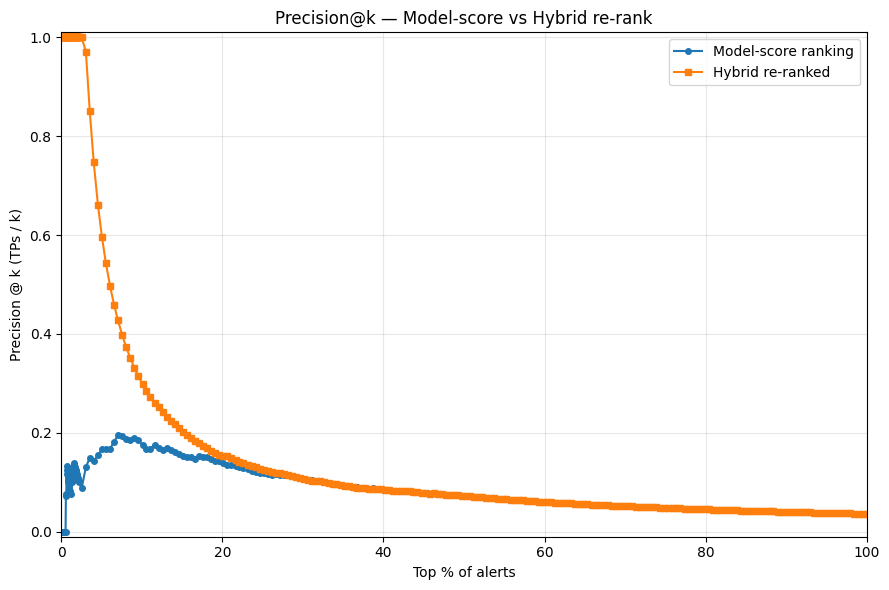


Precision at percent budgets (approx):
 Budget% |  Model Pct |  Hybrid Pct |  Model K |  Hybrid K
------------------------------------------------------------
   1.00% |      0.091 |       1.000 |       22 |        22
   2.00% |      0.111 |       1.000 |       45 |        45
   5.00% |      0.168 |       0.602 |      113 |       113
  10.00% |      0.177 |       0.301 |      226 |       226
  15.00% |      0.153 |       0.204 |      339 |       339


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ensure_is_malicious(df, test_df):
    """If df doesn't have is_malicious, merge it from test_df on ('user','day')."""
    if 'is_malicious' not in df.columns:
        join_cols = ['user', 'day'] if 'day' in df.columns else ['user']
        df = df.merge(test_df[join_cols + ['is_malicious']], on=join_cols, how='left')
        df['is_malicious'] = df['is_malicious'].fillna(0).astype(int)
    else:
        df['is_malicious'] = df['is_malicious'].astype(int)
    return df

def precision_curve(df_sorted, max_points=200):
    """
    Given df_sorted (descending ranking), compute (pct_of_list, precision_at_k, ks).
    Returns arrays suitable for plotting precision vs top-% of alerts.
    """
    n = len(df_sorted)
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    # cumulative true positives
    cum_tp = df_sorted['is_malicious'].astype(int).cumsum().to_numpy()

    # choose k points: dense at the start, then evenly spaced
    k_front = min(50, n)
    ks = np.unique(
        np.concatenate([
            np.arange(1, k_front+1),
            np.linspace(1, n, min(max_points, n)).astype(int)
        ])
    )
    ks = ks[ks <= n]

    precisions = np.array([cum_tp[k-1] / k for k in ks])
    percents = ks / n * 100.0
    return percents, precisions, ks

# -------------------------
# Prepare dataframes safely
# -------------------------
# Assumptions: test_df exists and contains 'is_malicious' & identifying keys (user, day).
# model_anoms is the model-score-sorted subset; anomalies_all is the hybrid-re-ranked DataFrame.
for name in ['test_df', 'model_anoms', 'anomalies_all']:
    if name not in globals():
        raise RuntimeError(f"{name} not found in the workspace. Please create it first.")

# make copies and ensure the 'day' column is normalized (if present)
test_df = test_df.copy()
if 'day' in test_df.columns:
    test_df['day'] = pd.to_datetime(test_df['day'])

model_anoms = model_anoms.copy()
if 'day' in model_anoms.columns:
    model_anoms['day'] = pd.to_datetime(model_anoms['day'])

anomalies_all = anomalies_all.copy()
if 'day' in anomalies_all.columns:
    anomalies_all['day'] = pd.to_datetime(anomalies_all['day'])

# Ensure is_malicious present on both ranked lists
model_anoms = ensure_is_malicious(model_anoms, test_df)
anomalies_all = ensure_is_malicious(anomalies_all, test_df)

# Optionally sort explicitly by score columns (safe-guards)
if 'anomaly_score' in model_anoms.columns:
    model_anoms = model_anoms.sort_values('anomaly_score', ascending=False).reset_index(drop=True)
if 'hybrid_score' in anomalies_all.columns:
    anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# Compute precision curves
pct_model, prec_model, ks_model = precision_curve(model_anoms)
pct_hybrid, prec_hybrid, ks_hybrid = precision_curve(anomalies_all)

# Plotting
plt.figure(figsize=(9,6))
if pct_model.size:
    plt.plot(pct_model, prec_model, marker='o', markersize=4, label='Model-score ranking', linewidth=1.5)
if pct_hybrid.size:
    plt.plot(pct_hybrid, prec_hybrid, marker='s', markersize=4, label='Hybrid re-ranked', linewidth=1.5)

plt.xlabel('Top % of alerts')
plt.ylabel('Precision @ k (TPs / k)')
plt.title('Precision@k — Model-score vs Hybrid re-rank')
plt.grid(alpha=0.3)
plt.legend()
plt.ylim(-0.01, 1.01)
plt.xlim(0, max( max(pct_model.max() if pct_model.size else 0,
                     pct_hybrid.max() if pct_hybrid.size else 0 ), 1.0))
plt.tight_layout()
plt.show()

# Print precision@some common percentage budgets for quick numeric comparison
percent_budgets = [0.01, 0.02, 0.05, 0.10, 0.15]  # 1%,2%,5%,10%,15%
print("\nPrecision at percent budgets (approx):")
print(f"{'Budget%':>8} | {'Model Pct':>10} | {'Hybrid Pct':>11} | {'Model K':>8} | {'Hybrid K':>9}")
print("-"*60)
for p in percent_budgets:
    # model
    if len(model_anoms):
        k_model = max(1, int(np.floor(p * len(model_anoms))))
        pm = model_anoms['is_malicious'].astype(int).head(k_model).sum() / k_model
    else:
        pm = np.nan
        k_model = 0
    # hybrid
    if len(anomalies_all):
        k_hybrid = max(1, int(np.floor(p * len(anomalies_all))))
        ph = anomalies_all['is_malicious'].astype(int).head(k_hybrid).sum() / k_hybrid
    else:
        ph = np.nan
        k_hybrid = 0

    print(f"{p*100:7.2f}% | {pm:10.3f} | {ph:11.3f} | {k_model:8d} | {k_hybrid:9d}")


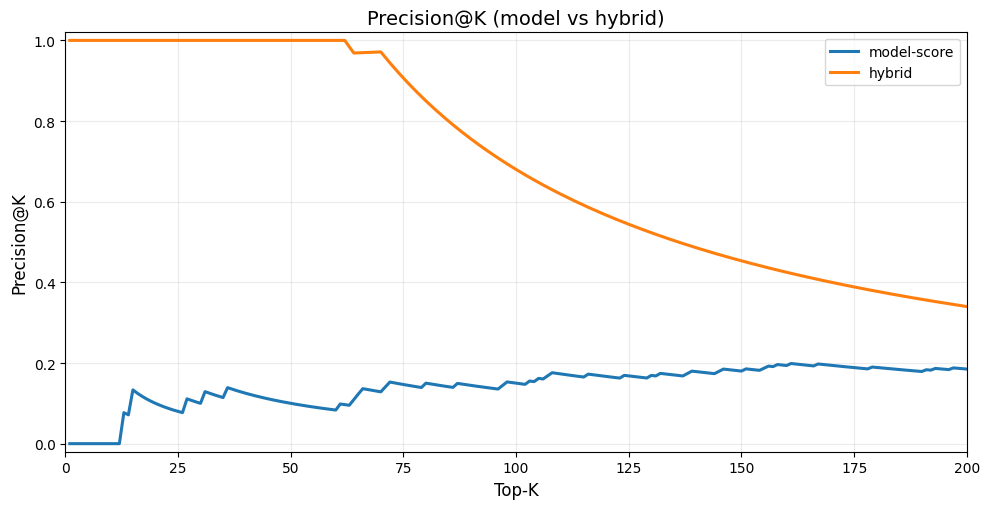

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# safety checks
for name in ['test_df', 'model_anoms', 'anomalies_all']:
    if name not in globals():
        raise RuntimeError(f"{name} not found. Please create it in the environment before running this cell.")

# copies & normalize day column if present
test_df = test_df.copy()
if 'day' in test_df.columns:
    test_df['day'] = pd.to_datetime(test_df['day'])

model_anoms = model_anoms.copy()
if 'day' in model_anoms.columns:
    model_anoms['day'] = pd.to_datetime(model_anoms['day'])

anomalies_all = anomalies_all.copy()
if 'day' in anomalies_all.columns:
    anomalies_all['day'] = pd.to_datetime(anomalies_all['day'])

def ensure_is_malicious(df, test_df):
    if 'is_malicious' not in df.columns:
        join_cols = ['user', 'day'] if 'day' in df.columns else ['user']
        df = df.merge(test_df[join_cols + ['is_malicious']], on=join_cols, how='left')
        df['is_malicious'] = df['is_malicious'].fillna(0).astype(int)
    else:
        df['is_malicious'] = df['is_malicious'].astype(int)
    return df

model_anoms = ensure_is_malicious(model_anoms, test_df)
anomalies_all = ensure_is_malicious(anomalies_all, test_df)

# ensure sorted descending by their respective scores if available
if 'anomaly_score' in model_anoms.columns:
    model_anoms = model_anoms.sort_values('anomaly_score', ascending=False).reset_index(drop=True)
if 'hybrid_score' in anomalies_all.columns:
    anomalies_all = anomalies_all.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# compute cumulative TPs arrays
cum_tp_model = model_anoms['is_malicious'].astype(int).cumsum().to_numpy()
cum_tp_hybrid = anomalies_all['is_malicious'].astype(int).cumsum().to_numpy()

len_model = len(model_anoms)
len_hybrid = len(anomalies_all)

MAX_K = 200
ks = np.arange(1, MAX_K+1)

# For k > length of list, assume missing alerts are non-alerts (i.e., zeros);
# precision = cum_tp_total / k.
prec_model = np.array([ (cum_tp_model[k-1] / k) if k <= len_model else (cum_tp_model[-1] / k if len_model>0 else 0.0)
                        for k in ks ])
prec_hybrid = np.array([ (cum_tp_hybrid[k-1] / k) if k <= len_hybrid else (cum_tp_hybrid[-1] / k if len_hybrid>0 else 0.0)
                         for k in ks ])

# Create plot with the requested look
plt.figure(figsize=(10,5.2))
plt.plot(ks, prec_model, linewidth=2.2, label='model-score')
plt.plot(ks, prec_hybrid, linewidth=2.2, label='hybrid')

plt.xlabel('Top-K', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.title('Precision@K (model vs hybrid)', fontsize=14)
plt.xlim(0, MAX_K)
plt.ylim(-0.02, 1.02)
plt.grid(alpha=0.25)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix

# Ground truth
y_true = test_df['is_malicious'].astype(int).values

# ---------------- Global threshold ----------------
global_threshold = np.percentile(train_scores, 95)
y_pred_global = (test_df['anomaly_score'] >= global_threshold).astype(int).values

# ---------------- Per-user threshold ----------------
pupct = PCT_THRESHOLD/100.0
per_user_thresh = train_ben_df.groupby('user')['anomaly_score'].quantile(pupct)
y_pred_peruser = test_df['anomaly_score'] >= test_df['user'].map(per_user_thresh).fillna(global_threshold)
y_pred_peruser = y_pred_peruser.astype(int).values

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec = tp / (tp + fp) if (tp+fp) > 0 else 0
    rec  = tp / (tp + fn) if (tp+fn) > 0 else 0
    fpr  = fp / (fp + tn) if (fp+tn) > 0 else 0
    return {"TP": tp, "FP": fp, "Precision": prec, "Recall": rec, "FPR": fpr}

# Compute both
metrics_global  = compute_metrics(y_true, y_pred_global)
metrics_peruser = compute_metrics(y_true, y_pred_peruser)

print("=== IsolationForest Metrics ===")
print("Global Threshold:")
for k,v in metrics_global.items():
    print(f"  {k:10s}: {v:.4f}" if isinstance(v,float) else f"  {k:10s}: {v}")

print("\nPer-User Threshold:")
for k,v in metrics_peruser.items():
    print(f"  {k:10s}: {v:.4f}" if isinstance(v,float) else f"  {k:10s}: {v}")


=== IsolationForest Metrics ===
Global Threshold:
  TP        : 82
  FP        : 7672
  Precision : 0.0106
  Recall    : 0.9647
  FPR       : 0.0477

Per-User Threshold:
  TP        : 82
  FP        : 2178
  Precision : 0.0363
  Recall    : 0.9647
  FPR       : 0.0135
